# Instanton density
The programme studies the instanton density of a given quantum configuration using a cooling algorithm, that consists in accepting only the Metropolis updates that lower the action. This brings the system to the nearest classical solution, which is the $\textit{instanton solution}$.

Input parameters, with default values:
- potential parameters: $\lambda=1$, $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points: $N=5000$
- lattice spacing: $a=0.05$
- number of Metropolis sweeps between cooling: $N_{sweeps}=100$
- final number of cooling sweeps: $N_{cool}=200$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
import random
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

In [3]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1);
eta = float(input("eta = ") or 1.4);
m = float(input("m = ") or 1/2);
hbar = 1;

lambda = 
eta = 
m = 


In [4]:
# Lattice parameters
N = int(input("N = ") or 5000);                # Use a larger value of N to make data smooth
a = float(input("a = ") or 0.05);
Nsweeps = int(input("Nsweeps = ") or 100);
Ncool = int(input("Ncool = ") or 200);

N = 
a = 
Nsweeps = 
Ncool = 


In [5]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def S(j, x, eta):
    if j == N-1:
        Action = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;       # Periodic boundary conditions
    else:
        Action = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;
    return Action

In [6]:
eps = float(input("epsilon = ") or 0.5);

# Function that updates x according to Metropolis algorithm
def update(y, eta):
    for j in range(N):
        old_y = y[j];                                    # Save the original values
        old_Sj = S(j, y, eta);
        y[j] = y[j] + random.gauss(0, eps);              # Update x[j]
        dS = S(j, y, eta) - old_Sj;                      # Change in action
        if math.exp(-dS) < random.gauss(0, eps):         # Metropolis acceptance criterium
            y[j] = old_y;                                # Restore the old value in case the condition is not satisfied
            
# Function that updates x cooling the system
def cooling(y, eta):
    for j in range(N):
        old_y = y[j];                                    # Save the original values
        old_Sj = S(j, y, eta);
        y[j] = y[j] + random.gauss(0, eps);              # Update x[j]
        dS = S(j, y, eta) - old_Sj;                      # Change in action
        if dS > 0:                                       # Cooling condition
            y[j] = old_y;                                # Restore the old value in case the condition is not satisfied

epsilon = 


## Evaluating the instanton density
In order to evaluate the instanton density, we can count the number of zero crossing of the cooled path; this is accomplished by a programme that computes the product of consecutive elements of $x$. If $x_jx_{j+1}<0$, this means that there is a zero between them, and the number of instantons is increased by one.

In [7]:
# Function that estimates the number of instantons of a given configuration
def instanton(x):
    count = 0;
    
    for j in range(len(x)-1):
        if x[j]*x[j+1] < 0:           # Condition for zero crossing
            count = count+1;          # If the condition is satisfied add a count
            
    return count

The instanton density is the evaluated performing $N_{sweeps}$ preparation sweeps on a cold path, which is then cooled $N_{cool}$ times; to see that the instanton density depends on the number of cooling sweeps, after each cooling step we compute its value and plot it as a function of $N_{cool}$. The whole procedure is also repeated for three different values of $\eta$.

In [8]:
# Instanton density evaluation
def instdensity(eta, Ncool):
    x = np.zeros(N);                 # Cold start
    Ninst = np.zeros(Ncool);
    
    for j in tqdm(range(Nsweeps), leave = False):          # Initial preparation through Metropolis sweeps
        update(x, eta)
    
    for j in tqdm(range(Ncool), leave = False):
        cooling(x, eta)                                    # Cooling sweeps
        Ninst[j] = instanton(x);                           # Compute the number of instantons
    
    return Ninst

Ninst = np.zeros([3, Ncool]);

# Repeat calculation for different values of eta
for j in tqdm(range(3), leave = False):
    eta0 = eta + 0.1*j;
    Ninst[j, :] = instdensity(eta0, Ncool);

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

### Curve fitting
We expect that the number of instantons measured using the cooling method is approximately given by the sum of two exponentials, describing the disappereance of quantum fluctuations on a time scale $\tau_{osc}$ and the instanton-anti-instanton annihilation occourring on a time scale $\tau_{tun}$:

$$
N_I(n_{cool})=N_{osc}\exp{\left(-n_{cool}\frac{a}{\tau_{osc}}\right)}+N_{tun}\exp{\left(-n_{cool}\frac{a}{\tau_{tun}}\right)}
$$

We can therefore try to fit the instanton density with this trial function, to see wether this approximation holds in the semiclassical limit, in which there is an exponentially large separation of scales between the tunneling time $\tau_{tun}$ and the scale of ordinary quantum fluctuations $\tau_{osc}$.

In [13]:
# Function for fitting
def doublexp(x, Nosc, tosc, Ntun, ttun):
    y = Nosc*np.exp(-x*a/tosc) + Ncool*np.exp(-x*a/ttun)
    return y

The result of the fitting can be compared with the analytic computation of small fluctuations around the instanton solution, which next-to-leading order in the semi-classical expansion give:

$$
n_I=8\eta^{\frac{5}{2}}\sqrt{\frac{2}{\pi}}\ \exp{\left(-S_0-\frac{71}{72S_0}\right)}
$$

where:
$$
S_0=\frac{4\eta^3}{3}
$$
is the classical action of the instanton.

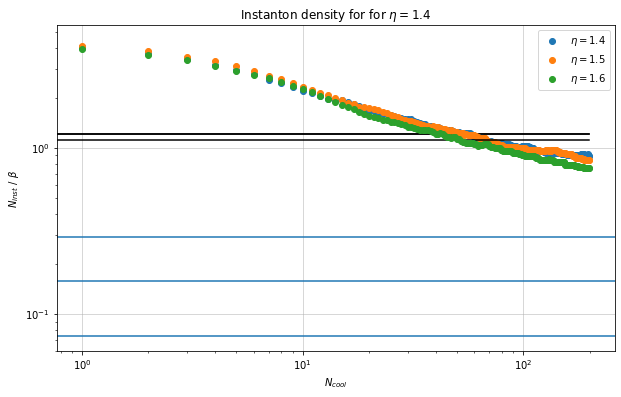

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

beta = N*a;                         # Total euclidean time

for j in range(3):
    xdata = np.asarray(list(range(Ncool)));
    ydata = Ninst[j, :]/beta;
    parameters, covariance = curve_fit(doublexp, xdata, ydata)
    
    Nosc = parameters[0];
    tosc = parameters[1];
    Ntun = parameters[2];
    ttun = parameters[3];
    
    fit = doublexp(xdata, Nosc, tosc, Ntun, ttun)       # Double exponential fitting
    ax.plot(xdata, fit, '-', color = 'black')
    
    eta0 = eta + 0.1*j;
    ax.plot(xdata, ydata, 'o' , label = '$\eta = $'+str(round(eta0, 1)));         # Cooling data
    
    S0 = 4*eta0**3/3;
    ax.axhline(y = 8*eta0**2.5*np.sqrt(2/np.pi)*np.exp(-S0-71/(72*S0)))           # Exact result at two-loop

ax.set_xlabel('$N_{cool}$');
ax.set_ylabel('$N_{inst}\ /\ \\beta$');
plt.grid(linewidth=0.5);
plt.title('Instanton density for for $\eta =$'+str(eta));
ax.set_xscale('log');
ax.set_yscale('log');
plt.legend();
plt.show()

### Analysis of $\eta$ dependence
A more refined analysis can be done computing the instanton density as a function of the potential parameter $\eta$, and comparing it with the 1- and 2-loop results coming from WKB, as well as $\Delta E/2$, where $\Delta E$ is the energy splitting between the first and second excited state. In particular, we find that they all become equivalent in the semi-classical limit $\eta\to\infty$.

In [15]:
Ngrid = 1001;                                      # Parameters for exact diagonalization
xmin = -5;
xmax = 5;

xvec = np.linspace(xmin, xmax, Ngrid);

etaMin = float(input("etaMin = ") or 0.2);
etaMax = float(input("etaMax = ") or 1.7);
Nsteps = int(input("Nsteps = ") or 50);
Neig = 2;                                          # We need only the first two eigenvalues

Ncool = 10;                                        # A smaller number of cooling sweeps is enough

eta_vector = np.zeros(Nsteps+1);                   # Values of eta explored
eig_vector = np.zeros((Neig, Nsteps+1));           # Eigenvalues
one_loop = np.zeros(Nsteps+1);                     # One-loop approximation
two_loop = np.zeros(Nsteps+1);                     # Two-loop approximation
Ninst = np.zeros((Nsteps+1, Ncool));               # Number of instantons via cooling
Ninst_ten = np.zeros(Nsteps+1);                    # Number of instantons after 10 cooling sweeps

# For exact diagonalization ###################################################################################################
# Potential
xvec = np.linspace(xmin, xmax, Ngrid);     # Vector spanning from xmin to xmax with Ngrid points
Vx = Lambda*(xvec**2-eta**2)**2;

# Kinetic energy discretization
dx = np.diff(xvec).mean();     # Grid resolution
diag = -2*np.ones(Ngrid);      # -2f(x)
offdiag = np.ones(Ngrid-1);    # f(x+dx) and f(x-dx)

d2grid = np.mat(np.diag(diag,0) + np.diag(offdiag,-1) + np.diag(offdiag,1))/dx**2;     # Discretized second derivative

# Avoid problems at the edge of the grid
d2grid[0,:] = 0;
d2grid[Ngrid-1,:] = 0;

Ekin = -hbar**2/(2*m)*d2grid;

# Potential energy discretization
Epot = np.mat(np.diag(Vx, 0))
###############################################################################################################################
 
# Loop over eta values
for step in tqdm(range(Nsteps+1), leave = False):
    eta = etaMin + step*(etaMax-etaMin)/Nsteps;
        
    Vx = Lambda*(xvec**2-eta**2)**2;
    Epot = np.mat(np.diag(Vx, 0));
        
    H = Ekin + Epot;
    w, v = LA.eig(H);
        
    sortinds = np.argsort(w);
    EigVals = w[sortinds];
        
    eta_vector[step] = eta;
        
    for eig in range(Neig):
        eig_vector[eig, step] = EigVals[eig];                     # Exact diagonalization
    
    S0 = 4*eta**3/3;                                              # Classical action
    one_loop[step] = 8*eta**2.5*np.sqrt(2/np.pi)*np.exp(-S0);     # One-loop approximation
    two_loop[step] = one_loop[step]*np.exp(-71/(72*S0));          # Two-loop approximation
    
    Ninst[step, :] = instdensity(eta, Ncool);                     # Instanton density
    Ninst_ten[step] = Ninst[step, Ncool-1];

etaMin = 
etaMax = 
Nsteps = 


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

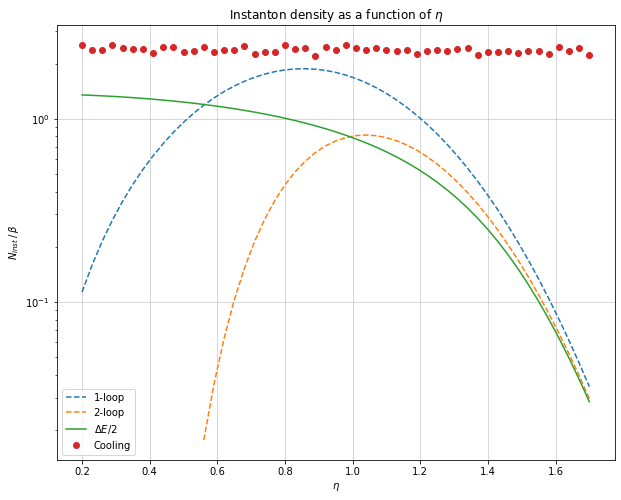

In [16]:
# Plotting the results
fig, ax = plt.subplots(figsize=(10,8));
ax.plot(eta_vector, one_loop, '--', label = '1-loop')
ax.plot(eta_vector[12:len(eta_vector)], two_loop[12:len(eta_vector)], '--', label = '2-loop')
ax.plot(eta_vector, (eig_vector[1,:] - eig_vector[0,:])/2, '-', label = '$\Delta E/2$')            # Removing too low values
ax.plot(eta_vector, Ninst_ten/beta, 'o', label = 'Cooling')
ax.set_ylabel('$N_{inst}\,/\,\\beta$');
ax.set_xlabel('$\eta$');
plt.grid(linewidth=0.5);
ax.set_yscale('log');
plt.title('Instanton density as a function of $\eta$');
plt.legend();
plt.show()

## Adiabatic switching
It is possible to perform a Monte Carlo computation of the instanton density on a small lattice employing the adiabatic switching technique. We introduce a new action $S_\alpha=S_{Gauss}+\alpha\Delta S$, with $\Delta S=S-S_{Gauss}$, which interpolates between the full action and a Gaussian effective potential. The exact quantum weight of an instanton can be determined by integration over the coupling constant $\alpha$:

$$
n=n_{Gauss}\ \exp{\left[-\int_0^1 d\alpha\, \left(\left<\Delta S\right>_\alpha^{(1)}-\left<\Delta S\right>_\alpha^{(0)}\right)\right]}
$$

where $\left<\cdot\right>_\alpha^{(n)}$ is an expectation value in the $n$-instanton sector at coupling $\alpha$. A smaller value of $N$ is required, in order to suppress transitions between the one-instanton sector and the higher-instanton sectors; for the same reason, we reduce the amplitude of the fluctuations $\varepsilon$, as well.

In [27]:
N = int(input("N = ") or 100);
beta = N*a;                           # A smaller value of beta is needed
eps = 0.1;                            # Reduce fluctuations

N = 


### Sample paths
We can visualize the paths corresponding to zero- and one-instanton sectors though the following code. The only thing to remark is that, in the case of one-instanton paths, after each update a constraint is included, which forces the instanton to keep the same position, in the form: $x_{N/2}\equiv 0$.

  0%|          | 0/100 [00:00<?, ?it/s]

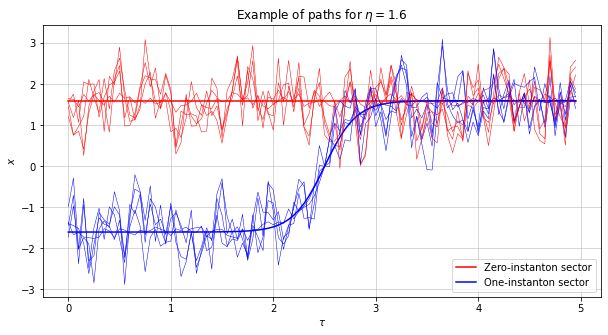

In [29]:
eta = 1.6;
x0 = np.zeros(N);              # Initialize zero-instanton sector
x1 = np.zeros(N);              # Initialize one-instanton sector
tau_vec = np.zeros(N);

tau_i = beta/2;                # Instanton centre
w = 4*eta;                     # Omega

x0 = x0 + eta;                 # Zero-instanton starting path

for j in range(N):             # One-instanton starting path
    x1[j] = eta*(np.tanh(w/2*(a*j-tau_i)));
    tau_vec[j] = j*a;

# Plotting the results
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(tau_vec, x0, '-', label = 'Zero-instanton sector', color = 'red');
ax.plot(tau_vec, x1, '-', label = 'One-instanton sector', color = 'blue');
ax.set_xlabel('$\\tau$');
ax.set_ylabel('$x$');
plt.grid(linewidth=0.5);
plt.title('Example of paths for $\eta = $'+str(eta));
plt.legend();

for j in tqdm(range(Nsweeps), leave = False):
    update(x0, eta)
    update(x1, eta)
    x1[int(N/2)] = 0;          # Constraint which keeps the location of the instanton fixed
    
    if j%(Nsweeps/5) == 0:
        ax.plot(tau_vec, x0, '-', color = 'red', linewidth = 0.5);
        ax.plot(tau_vec, x1, '-', color = 'blue', linewidth = 0.5);
    
plt.show()

### Evaluating the action

In [ ]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def S_ads(j, x, alpha, N):
    
    if j == N-1:
        Kin = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a);       # Periodic boundary conditions
    else:
        Kin = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a);
            
    V0 = 1/2*m*w0**2*x[j]**2;                                  # Reference system potential
    V1 = (x[j]**2-eta**2)**2;                                  # Double well potential
    
    V = alpha*(V1-V0) + V0;                                    # Interpolation between the two
    Action = Kin + a*V;
    deltaS = a*(V1-V0);                                        # Difference in action in the two cases
                                                               # (only for j-dependent terms)
    return Action, deltaS

In [ ]:
# Initialize the vectors needed
mean_deltaS = np.zeros([2*Nswitch+1, n]);         # Mean value of the difference in action
mean_deltaS2 = np.zeros([2*Nswitch+1, n]);        # Mean value of the squared difference in action

alpha_vec = np.zeros(2*Nswitch+1);                # Values of alpha explored

integral_dS1 = np.zeros(n);                       # Integrals of the mean value, forward and backward
integral_dS2 = np.zeros(n);

for iT in tqdm(range(n), leave = False):
    dalpha = 1/Nswitch;                           # Lattice separation in alpha space
    beta = N*a;                                   # Total euclidean time
    T_vec[iT] = 1/beta;                           # Corresponding temperature
    
    x = np.zeros(N);                              # Cold start
    
    for ialpha in tqdm(range(2*Nswitch+1), leave = False):      # Loop on twice the number of steps
        if ialpha < Nswitch:                                    # (to take into account hysteresis effects)
            alpha = ialpha*dalpha;
            alpha_vec[ialpha] = alpha;
        else:
            alpha = 2-ialpha*dalpha;
            alpha_vec[ialpha] = alpha;

        for j in range(5*Ncor):                                # Initial thermalization
            update(x, alpha, N);
        for k in tqdm(range(Nsweeps), leave = False):
            for j in range(Ncor):                              # Thermalization steps between each measurement
                update(x, alpha, N);

            deltaS = 0;                                        # Compute the difference in action
            for j in range(N):                                 # Sum over all lattice points
                _, delS = S(j, x, alpha, N);
                deltaS = deltaS + delS;
            
            mean_deltaS[ialpha, iT] = mean_deltaS[ialpha, iT] + deltaS;

    mean_deltaS[:, iT] = mean_deltaS[:, iT] / Nsweeps;         # Compute the mean value over configurations

    # Integration with trapeziodal rule of the mean values w.r.t. alpha
    # (1 is in going forward, 2 backward, in order to take into account possible hysteresis effects)
    integral_dS1[iT] = np.trapz(mean_deltaS[0:Nswitch+1, iT], alpha_vec[0:Nswitch+1]);
    integral_dS2[iT] = np.trapz(mean_deltaS[Nswitch:2*Nswitch+1, iT], alpha_vec[Nswitch:2*Nswitch+1]);

    Z0 = np.exp(-beta*w0/2) / (1-np.exp(-beta*w0));                            # Partition function of the reference system 
    
    logZ_vec[iT] = np.log(Z0) - (integral_dS1[iT] + integral_dS2[iT])/2;       # Adiabatic switching formula
    F_vec[iT] = -logZ_vec[iT]*T_vec[iT];                                       # Free energy
    
    N = N*2;          # Update the value of N at the end of each iteration
    
    
# Plotting the results
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(T_vec, F_vec, 'o');
ax.set_xlabel('$T$');
ax.set_ylabel('$F$');
ax.set_xscale('log');
plt.grid(linewidth=0.5);
plt.title('Free energy');
plt.show();